In [4]:
#Haseeb Khan project final:
import numpy as np
from keras import backend as K
from keras.models import load_model

from matplotlib import pyplot as plt
import cv2

"""
https://github.com/gbusr/YAD2K provides the base work for implementation of YOLO v2 in Keras and Tensorflow
yad2k.py converts the YOLO's Darknet weights to Keras readable format
"""
from yad2k.models.keras_yolo import yolo_eval, yolo_head

/anaconda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
color = (0, 0, 255)
model_path = 'model_data/yolo.h5'
anchors_path = 'model_data/yolo_anchors.txt'
classes_path = 'model_data/coco_classes.txt'

In [6]:
# Detection Class
class Detector:
    # Class initialization
    def __init__(self, model_path, classes_path, anchors_path):
        # Open Tensorflow session
        self.session = K.get_session()
        
        # Load classes
        with open(classes_path) as f:
            self.class_names = f.readlines()
            self.class_names = [c.strip() for c in self.class_names]
            
        # Load anchors
        with open(anchors_path) as f:
            self.anchors = f.readline()
            self.anchors = [float(x) for x in self.anchors.split(',')]
            self.anchors = np.array(self.anchors).reshape(-1, 2)
        
        # Load model
        self.model = load_model(model_path)
        
        # Check if model is fully convolutional, assuming channel last order
        self.model_image_size = self.model.layers[0].input_shape[1:3]
        
        # Generate output tensor targets
        self.input_image_shape = K.placeholder(shape = (2, ))
        self._boxes, self._scores, self._classes = self.generate_tensor_targets(0.3, 0.5)
        
    # Generate output tensor targets for filtered bounding boxes
    def generate_tensor_targets(self, score_threshold = 0.2, iou_threshold = 0.5):
        model_outputs = yolo_head(self.model.output, self.anchors, len(self.class_names))      
        return yolo_eval(model_outputs,
                         self.input_image_shape,
                         score_threshold = score_threshold,
                         iou_threshold = iou_threshold)        
            
    # Resize image
    def resize_image(self, image):
        # Resize image
        if self.model_image_size != (None, None):
            # Fit to the fixed input shape
            new_image_size = tuple(reversed(self.model_image_size))
        else:
            # width and height as multiples of 32.
            new_image_size = (image.width - (image.width % 32), image.height - (image.height % 32))
            
        return cv2.resize(image, new_image_size)
    
    # Preprocess image
    def process_image(self, filename):
        image = cv2.imread(filename)
        # Resize image
        resized_image = self.resize_image(image)
        # Convert to image to array
        image_data = resized_image.astype(np.float32)
        # Normalize image data
        image_data /= 255.
        # Add batch dimension
        return np.expand_dims(image_data, 0), image.shape
    
    # Filter classes
    def filter_classes(self, boxes, scores, classes, class_filter):
        # If no filter
        if len(class_filter) is 0:
            return boxes, scores, classes
        
        # Filter the classes
        out_boxes = []; out_scores = []; out_classes = []
        for i, c in list(enumerate(classes)):
            if self.class_names[c] in class_filter:
                out_boxes.append(boxes[i])
                out_scores.append(scores[i])
                out_classes.append(classes[i])
                
        return out_boxes, out_scores, out_classes
    
    # Feed image for detection
    def feed(self, filename, class_filter):
        # Process image for feed
        image_data, image_shape = self.process_image(filename)
        # Feed image data into tensorflow
        feed = {self.model.input: image_data,
                self.input_image_shape: image_shape[0:2],
                K.learning_phase(): 0}
        # Run tensor
        boxes, scores, classes = self.session.run([self._boxes, self._scores, self._classes],
                                                  feed_dict = feed)
        
        return self.filter_classes(boxes, scores, classes, class_filter)
    
    # Annotate the classes
    def annotate_image(self, filename, boxes, scores, classes):        
        img = cv2.imread(filename)
        for i, box in list(enumerate(boxes)):
            class_name = self.class_names[classes[i]]
            # Select annotation color
            #Cars qualify as high tensile collision objects so are boxed in red
            if class_name == 'car':
                color = (0, 0, 255)
            #Person qualify as low tensile high value collision objects so are boxed in green
            elif class_name == 'person':
                color = (0,255, 0)
            #Everything else is boxed in yellow  
            else:
                color = (0, 255, 255)
            
            top, left, bottom, right = box
            cv2.rectangle(img, (left, top), (right, bottom), color, 2)
            font = cv2.FONT_HERSHEY_COMPLEX_SMALL
            annotation = class_name + ': ' + str(scores[i])
            cv2.putText(img, annotation, (left, int(top) - 5), font, 1, color, 1)

        # Display annotated image
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Fit image width
        fig_size = (img.shape[1] * 16/1200)
        # display on 16 figure columns if larger than 1200 px width
        fig_size = min(fig_size, 16)
        # fir to 8 columns for smaller width images
        fig_size = max(fig_size, 8)
        plt.figure(figsize = (fig_size, fig_size))
        plt.imshow(img_rgb)
        plt.show()
        
    # Detect and Annotate
    def run_cars(self, filename):
        # Feed image
        boxes, scores, classes = self.feed(filename, class_filter = ['car'])
        # Annotate image
        self.annotate_image(filename, boxes, scores, classes)
        

In [7]:
# Create detector object
detector = Detector(model_path, classes_path, anchors_path)
# detector.model.summary()

/anaconda/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


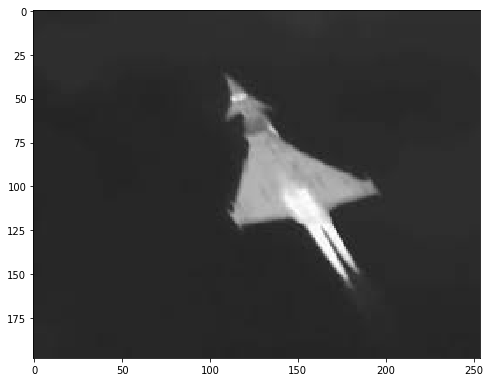

In [20]:
# Feed image:
filename = 'images/flirT.jpg'
boxes, scores, classes = detector.feed(filename, class_filter = [])
# Annotate image:
detector.annotate_image(filename, boxes, scores, classes)

In [ ]:
# sess.close()